<a href="https://colab.research.google.com/github/danielbehargithub/LinkedIn_Salary/blob/main/Wage_range_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lightgbm
!pip install --upgrade lightgbm
!pip install pycountry_convert

In [224]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry_convert as pc

import xgboost as xgb
import lightgbm as lgb

# Load the dataset
data = pd.read_csv('salaries.csv')
data = data.drop(columns=["salary", "salary_currency"])

# Identify categorical columns dynamically (excluding the target column)
categorical_columns = [
    'experience_level', 'employment_type', 'employee_residence',
    'company_location', 'company_size', 'job_title', 'remote_ratio'
]

# Convert categorical columns to categorical dtype
for col in categorical_columns:
    data[col] = data[col].astype('category')


# Print the number of unique values for each categorical column
print("\n🔹 Unique value count per categorical column:\n")
for col in categorical_columns:
    unique_count = data[col].nunique()
    print(f"{col}: {unique_count} unique values")



🔹 Unique value count per categorical column:

experience_level: 4 unique values
employment_type: 4 unique values
employee_residence: 94 unique values
company_location: 87 unique values
company_size: 3 unique values
job_title: 298 unique values
remote_ratio: 3 unique values


In [225]:
# Count the number of records for each job title
job_counts = data['job_title'].value_counts()

# Calculate the percentage of records for each job title
job_percentage = (job_counts / len(data)) * 100



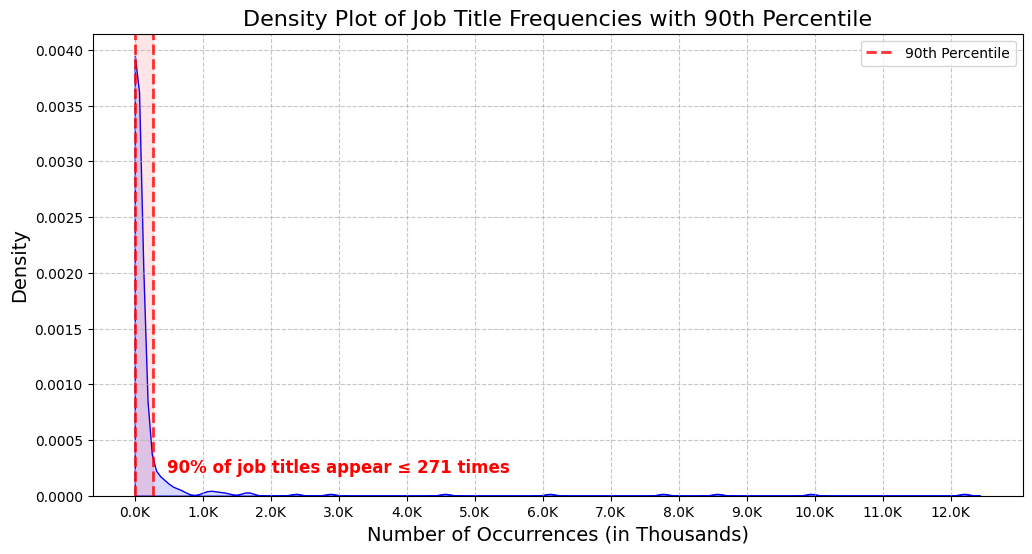

In [178]:
# Compute the 90th percentile of job title frequencies
percentile_90 = np.percentile(job_counts, 90)

# Create the density plot
plt.figure(figsize=(12, 6))
sns.kdeplot(job_counts, fill=True, color="blue", alpha=0.15, bw_adjust=0.2, clip=(0, None))

# Vertical line to mark the cutoff
plt.axvline(10, color="red", linestyle="--", linewidth=2, alpha=0.8)

# Highlight the area under the 90th percentile
plt.axvspan(0, percentile_90, color="red", alpha=0.1)

# Vertical line marking the 95th percentile
plt.axvline(percentile_90, color="red", linestyle="--", linewidth=2, alpha=0.8, label="90th Percentile")


# Add a text annotation to indicate the 95th percentile threshold
plt.text(percentile_90 + 200, plt.ylim()[1] * 0.05,
         f"90% of job titles appear ≤ {int(percentile_90)} times",
         ha="left", fontsize=12, color="red", weight="bold")

# Titles and labels
plt.title("Density Plot of Job Title Frequencies with 90th Percentile", fontsize=16)
plt.xlabel("Number of Occurrences (in Thousands)", fontsize=14)
plt.ylabel("Density", fontsize=14)

# Improve X-axis ticks resolution
plt.xticks(np.arange(0, job_counts.max() + 500, step=1000),
           labels=[f"{x/1000:.1f}K" for x in np.arange(0, job_counts.max() + 500, step=1000)])

plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()


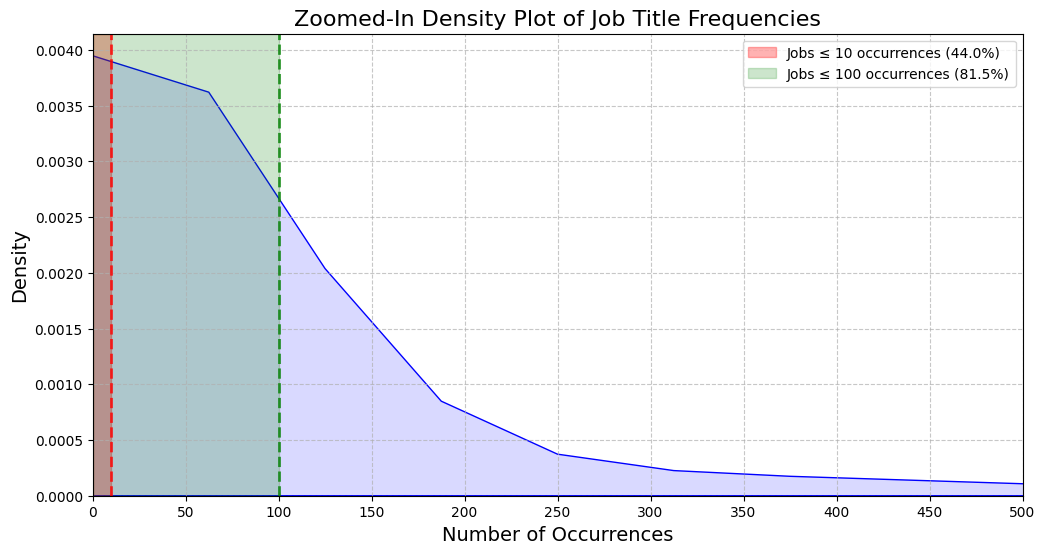

In [126]:
# Compute percentage of jobs appearing ≤ 100 times
rare_jobs_100 = job_counts[job_counts <= 100].count()
rare_jobs_percentage_100 = (rare_jobs_100 / len(job_counts)) * 100

# Compute percentage of jobs appearing ≤ 10 times
rare_jobs_10 = job_counts[job_counts <= 10].count()
rare_jobs_percentage_10 = (rare_jobs_10 / len(job_counts)) * 100

# Create the density plot
plt.figure(figsize=(12, 6))
sns.kdeplot(job_counts, fill=True, color="blue", alpha=0.15, bw_adjust=0.2, clip=(0, None))

# Highlight area for jobs with ≤ 10 occurrences (in red)
plt.axvspan(0, 10, color="red", alpha=0.3, label=f"Jobs ≤ 10 occurrences ({rare_jobs_percentage_10:.1f}%)")

# Highlight area for jobs with ≤ 100 occurrences (in green)
plt.axvspan(0, 100, color="green", alpha=0.2, label=f"Jobs ≤ 100 occurrences ({rare_jobs_percentage_100:.1f}%)")

# Vertical lines marking the cutoffs
plt.axvline(10, color="red", linestyle="--", linewidth=2, alpha=0.8)
plt.axvline(100, color="green", linestyle="--", linewidth=2, alpha=0.8)

# Titles and labels
plt.title("Zoomed-In Density Plot of Job Title Frequencies", fontsize=16)
plt.xlabel("Number of Occurrences", fontsize=14)
plt.ylabel("Density", fontsize=14)

# Limit the x-axis range to zoom in on job titles ≤ 500 occurrences
plt.xlim(0, 500)

# Improve X-axis ticks resolution
plt.xticks(np.arange(0, 550, step=50), labels=[f"{x}" for x in np.arange(0, 550, step=50)])

plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()


Analysis of Job Title Frequency Distribution
The two density plots provide insights into the distribution of job title occurrences in the dataset.

Overall Distribution:

The first plot presents a full view of job title frequencies.
It highlights that 90% of job titles appear fewer than 271 times, emphasizing the dominance of less frequent job titles.

Zoomed-In View (≤ 500 occurrences):

The second plot zooms in on job titles with 500 or fewer occurrences to provide a clearer perspective.
The red region represents job titles that appear ≤ 10 times, showcasing their significant proportion- 44% of all the data
The green region highlights job titles with ≤ 100 occurrences, reinforcing the long-tail nature of the dataset.

This visualization confirms that the majority of job titles have a very low representation in the dataset.

Key Insight: The dataset is highly skewed, with a small number of job titles appearing frequently, while most job titles have very few occurrences. This characteristic should be considered in modeling and feature engineering.



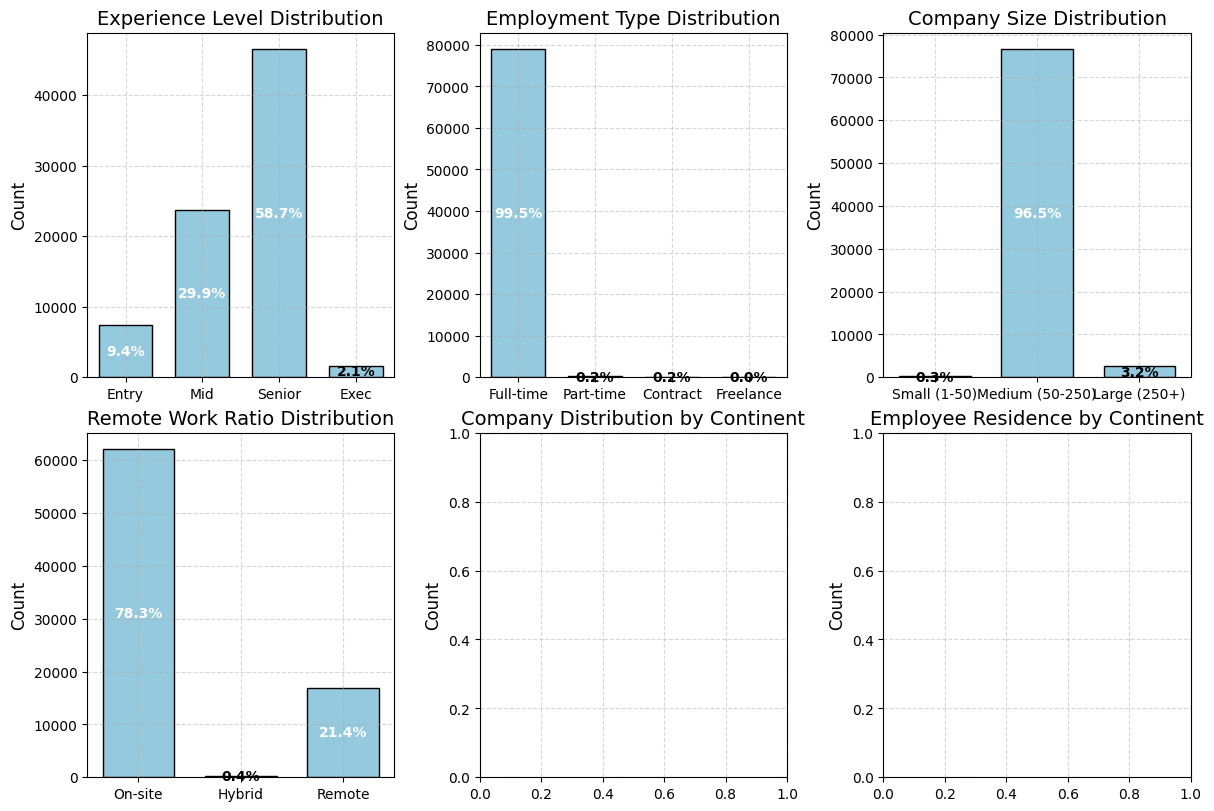

In [223]:
# Define category explanations
category_explanations = {
    "experience_level": {
        "labels": {"EN": "Entry", "MI": "Mid", "SE": "Senior", "EX": "Exec"},
        "title": "Experience Leve Distribution"
    },
    "employment_type": {
        "labels": {"FT": "Full-time", "PT": "Part-time", "CT": "Contract", "FL": "Freelance"},
        "title": "Employment Type Distribution"
    },
    "company_size": {
        "labels": {"S": "Small (1-50)", "M": "Medium (50-250)", "L": "Large (250+)"},
        "title": "Company Size Distribution"
    },
    "remote_ratio": {
        "labels": {0: "On-site", 50: "Hybrid", 100: "Remote"},
        "title": "Remote Work Ratio Distribution"
    }
}

# Create subplots in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)
axes = axes.flatten()

# Plot each categorical column
for i, (col, info) in enumerate(category_explanations.items()):
    counts = data[col].value_counts()

    # Ensure correct data type for remote_ratio
    if col == "remote_ratio":
        mapping = {"On-site": 0, "Hybrid": 50, "Remote": 100}
        counts.index = counts.index.map(lambda x: mapping.get(x, x))

    # Reindex to ensure correct order (fill missing values with 0)
    counts = counts.reindex(info["labels"].keys(), fill_value=0)

    # Create bar plot with reduced bar width
    bars = sns.barplot(x=[info["labels"][k] for k in counts.index], y=counts.values, ax=axes[i],
                       color="skyblue", edgecolor="black", width=0.7)

    # Titles and labels
    axes[i].set_title(info["title"], fontsize=14)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Count", fontsize=12)

    # Add percentage labels inside bars
    for p, label in zip(axes[i].patches, counts.values):
        height = p.get_height()
        text_color = "white" if height > max(counts.values) * 0.15 else "black"  # White for tall bars

        axes[i].text(p.get_x() + p.get_width() / 2., height / 2,  # Placing in center
                     f'{label / data.shape[0] * 100:.1f}%',
                     ha='center', va='center', fontsize=10, color=text_color, weight="bold")

    # Add dashed grid with lower opacity
    axes[i].grid(True, linestyle="--", alpha=0.5)  # Lighter grid

plt.show()


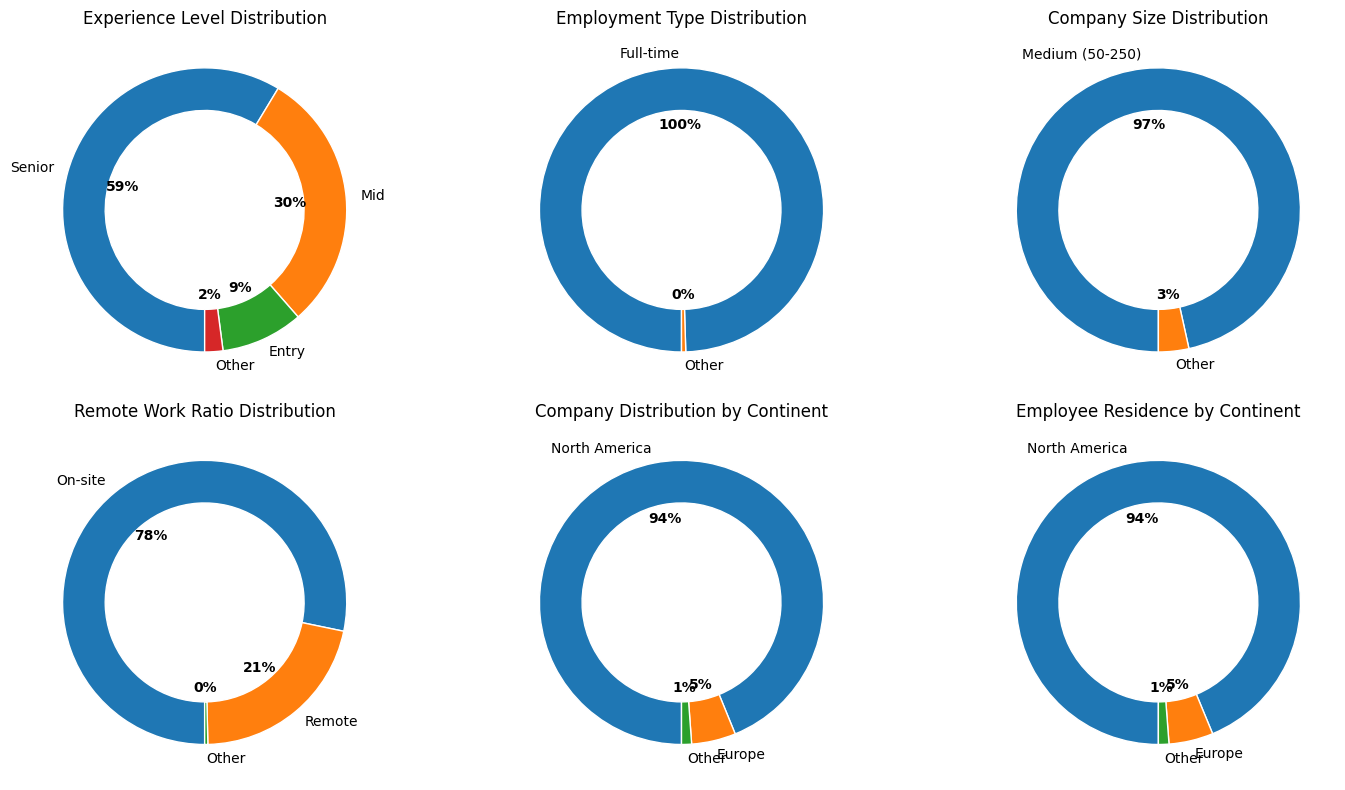

In [221]:
# פונקציה להמרת קוד ISO-2 ליבשת
def country_to_continent(country_code):
    try:
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        continent_names = {
            "NA": "North America",
            "SA": "South America",
            "EU": "Europe",
            "AF": "Africa",
            "AS": "Asia",
            "OC": "Oceania"
        }
        return continent_names.get(continent_code, "Other")
    except:
        return "Other"  # ברירת מחדל אם המדינה לא מזוהה

# חישוב יבשת לכל עמודה בנפרד
data["company_continent"] = data["company_location"].apply(country_to_continent)
data["residence_continent"] = data["employee_residence"].apply(country_to_continent)

# עדכון קטגוריות מוסברות
category_explanations = {
    "experience_level": {
        "labels": {"EN": "Entry", "MI": "Mid", "SE": "Senior", "EX": "Exec"},
        "title": "Experience Level Distribution"
    },
    "employment_type": {
        "labels": {"FT": "Full-time", "PT": "Part-time", "CT": "Contract", "FL": "Freelance"},
        "title": "Employment Type Distribution"
    },
    "company_size": {
        "labels": {"S": "Small (1-50)", "M": "Medium (50-250)", "L": "Large (250+)"},
        "title": "Company Size Distribution"
    },
    "remote_ratio": {
        "labels": {0: "On-site", 50: "Hybrid", 100: "Remote"},
        "title": "Remote Work Ratio Distribution"
    },
    "company_continent": {
        "labels": {},  # נמלא אוטומטית לפי נתוני היבשות
        "title": "Company Distribution by Continent"
    },
    "residence_continent": {
        "labels": {},  # נמלא אוטומטית לפי נתוני היבשות
        "title": "Employee Residence by Continent"
    }
}

# יצירת דונאט צ'ארטים
fig, axes = plt.subplots(2, 3, figsize=(15, 8))  # שינוי לגריד 2x3
axes = axes.flatten()

for i, (col, info) in enumerate(category_explanations.items()):
    counts = data[col].value_counts().to_dict()
    total = sum(counts.values())

    # קיבוץ קטגוריות קטנות
    small_categories = {k: v for k, v in counts.items() if (v / total) * 100 < 5}
    large_categories = {k: v for k, v in counts.items() if (v / total) * 100 >= 5}

    if small_categories:
        small_total = sum(small_categories.values())
        large_categories["Other"] = small_total

    # יצירת תוויות
    labels = [info["labels"].get(k, k) for k in large_categories.keys()]
    values = list(large_categories.values())

    # יצירת דונאט
    wedges, texts, autotexts = axes[i].pie(values, labels=labels, autopct='%1.f%%',
                                           startangle=270, counterclock=False,
                                           wedgeprops=dict(width=0.3, edgecolor="w"))

    for text in autotexts:
        text.set_color("black")
        text.set_fontweight("bold")

    axes[i].set_title(info["title"], fontsize=12)

plt.tight_layout()
plt.show()


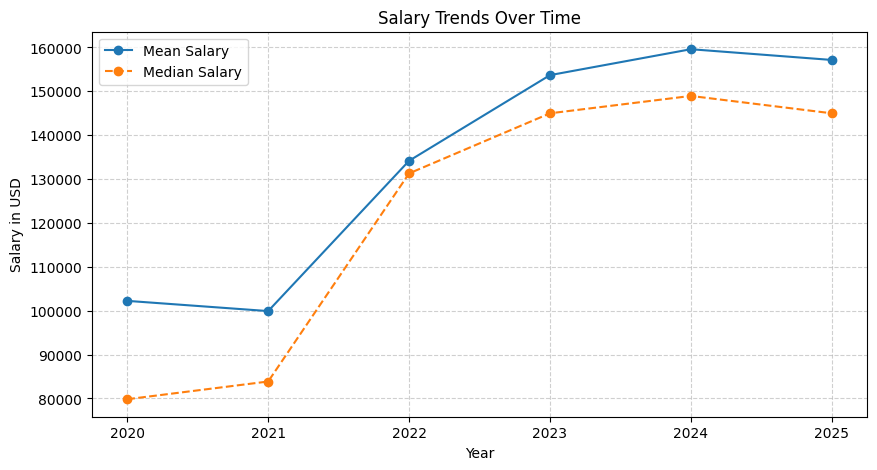

In [226]:
import matplotlib.pyplot as plt
import seaborn as sns

# חישוב ממוצע וחציון שכר לפי שנה
salary_trend = data.groupby("work_year")["salary_in_usd"].agg(["mean", "median"])

# יצירת גרף קווי
plt.figure(figsize=(10, 5))
plt.plot(salary_trend.index, salary_trend["mean"], marker="o", label="Mean Salary")
plt.plot(salary_trend.index, salary_trend["median"], marker="o", label="Median Salary", linestyle="--")

plt.title("Salary Trends Over Time")
plt.xlabel("Year")
plt.ylabel("Salary in USD")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


In [ ]:
# קביעת חסם מינימלי
min_threshold = 200

# ספירת התפקידים
job_counts = data['job_title'].value_counts()

# סינון תפקידים מתחת לחסם
filtered_data = data[data['job_title'].isin(job_counts[job_counts >= min_threshold].index)]

job_counts_filtered = filtered_data['job_title'].value_counts()
# בדיקת התוצאה
print(f"Total records before filtering: {len(data)}")
print(f"Total records after filtering: {len(filtered_data)}")
print(f"Number of unique job titles before: {len(job_counts)}")
print(f"Number of unique job titles after: {filtered_data['job_title'].nunique()}")


Total records before filtering: 79352
Total records after filtering: 72166
Number of unique job titles before: 298
Number of unique job titles after: 37


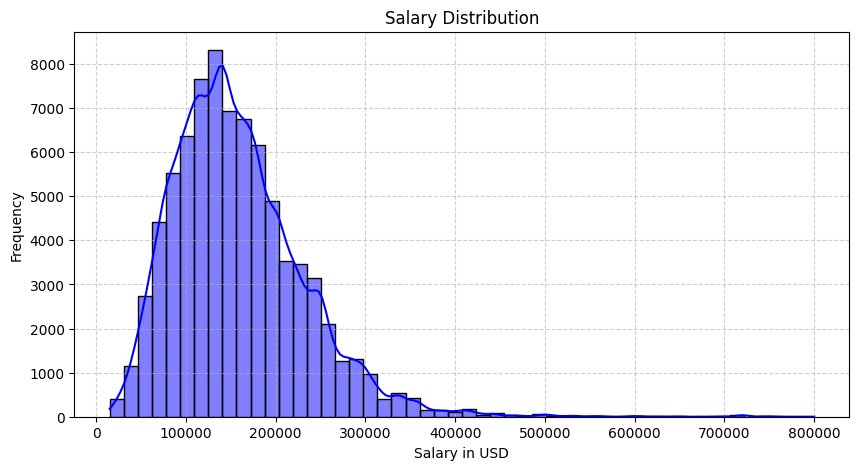

In [230]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(data["salary_in_usd"], bins=50, kde=True, color="blue")

plt.title("Salary Distribution")
plt.xlabel("Salary in USD")
plt.ylabel("Frequency")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


Till now- learned data

Now- try 3 algo: random forest, xgboost, lightgbm

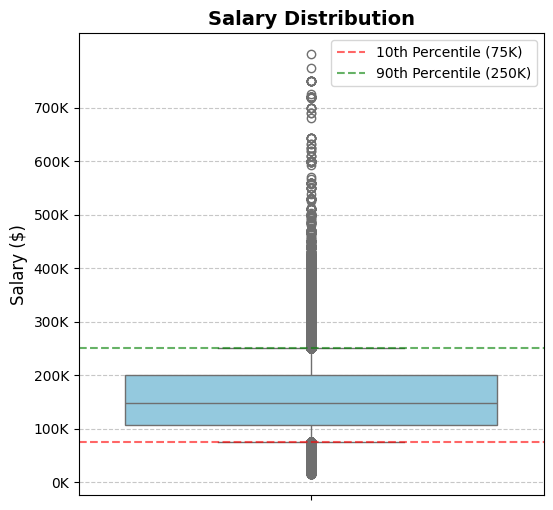

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# חישוב אחוזונים 10 ו-90
q10 = data['salary_in_usd'].quantile(0.10)
q90 = data['salary_in_usd'].quantile(0.90)

plt.figure(figsize=(6, 6))
sns.boxplot(y=data['salary_in_usd'], color="skyblue", whis=[10, 90])

# כותרת ותיוגים
plt.title("Salary Distribution", fontsize=14, fontweight='bold')
plt.ylabel("Salary ($)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# שינוי הסימון בציר ה-Y לאלפים (K)
plt.yticks(np.arange(0, data['salary_in_usd'].max(), step=100000),
           [f"{int(x/1000)}K" for x in np.arange(0, data['salary_in_usd'].max(), step=100000)])

# הוספת קווי מדריך לאחוזון 10 ו-90
plt.axhline(q10, color='red', linestyle='dashed', alpha=0.6, label=f"10th Percentile ({int(q10/1000)}K)")
plt.axhline(q90, color='green', linestyle='dashed', alpha=0.6, label=f"90th Percentile ({int(q90/1000)}K)")
plt.legend()

plt.show()


In [ ]:
# חישוב טווח השכר
salary_min = data['salary_in_usd'].min()
salary_max = data['salary_in_usd'].max()
salary_mean = data['salary_in_usd'].mean()

print(f"Minimum Salary: {salary_min:,.2f}")
print(f"Maximum Salary: {salary_max:,.2f}")
print(f"Mean Salary: {salary_mean:,.2f}")
salary_std = data['salary_in_usd'].std()
print(f"Standard Deviation of Salary: {salary_std:,.2f}")


Minimum Salary: 15,000.00
Maximum Salary: 800,000.00
Mean Salary: 158,017.05
Standard Deviation of Salary: 73,029.16


In [ ]:

# הפרדת משתנים תלויים ובלתי תלויים
X = data.drop(columns=['salary_in_usd'])  # הסרת עמודת המטרה
y = data['salary_in_usd']

# חלוקה לנתוני אימון ובדיקה
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# fot rf and xgboost
# One-Hot Encoding למשתנים קטגוריאליים
X_train_encoded = pd.get_dummies(X_train)
X_test_encoded = pd.get_dummies(X_test)


Naive model

In [ ]:
# חישוב תחזית בסיסית
baseline_prediction = np.mean(y_train)

# חישוב RMSE למודל בסיסי

rmse_baseline = np.sqrt(mean_squared_error(y_test, [baseline_prediction] * len(y_test)))

print(f"Baseline RMSE: {rmse_baseline:,.2f}")


Baseline RMSE: 73,351.77


linear model

In [ ]:
from sklearn.linear_model import LinearRegression
# התאמת מודל רגרסיה ליניארי
lr_model = LinearRegression()
lr_model.fit(X_train_encoded, y_train)

# חיזוי על נתוני הבדיקה
y_pred_lr = lr_model.predict(X_test_encoded)

# הערכת ביצועי המודל
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr= np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)
relative_rmse_lr = (rmse_lr / salary_mean) * 100

print(f"Linear Regression - MAE: {mae_lr:,.2f}, RMSE: {rmse_lr:,.2f}")
print(f"Relative RMSE: {relative_rmse_lr:.2f}%")

print(f"Explained Variance (R^2): {r2_lr:.2f}")


Linear Regression - MAE: 45,789.69, RMSE: 61,996.26
Relative RMSE: 39.24%
Explained Variance (R^2): 0.29


random forest:

In [ ]:

# התאמת המודל
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_encoded, y_train)

# חיזוי
y_pred_rf = rf_model.predict(X_test_encoded)

# הערכת ביצועים
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
relative_rmse_rf = (rmse_rf / salary_mean) * 100

print(f"Random Forest - MAE: {mae_rf:,.2f}, RMSE: {rmse_rf:,.2f}")
print(f"Explained Variance (R^2): {r2_rf:.2f}")
print(f"Relative RMSE: {relative_rmse_rf:.2f}%")


Random Forest - MAE: 45,000.94, RMSE: 61,155.39
Explained Variance (R^2): 0.30
Relative RMSE: 38.71%


xgboost

In [ ]:
# התאמת המודל
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train_encoded, y_train)

# חיזוי
y_pred_xgb = xgb_model.predict(X_test_encoded)

# הערכת ביצועים
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)
relative_rmse_xgb = (rmse_xgb / salary_mean) * 100

print(f"XGBoost - MAE: {mae_xgb:.2f}, RMSE: {rmse_xgb:,.2f}")
print(f"Explained Variance (R^2): {r2_xgb:.2f}")
print(f"Relative RMSE: {relative_rmse_xgb:.2f}")

XGBoost - MAE: 45008.57, RMSE: 61,182.65
Explained Variance (R^2): 0.30
Relative RMSE: 38.73


In [ ]:
# הגדרת מודל XGBoost עם תמיכה בקטגוריות
xgb_model_categorized = xgb.XGBRegressor(random_state=42, enable_categorical=True)

# אימון המודל
xgb_model_categorized.fit(X_train, y_train)

# חיזוי על נתוני הבדיקה
y_pred_xgb_categorized = xgb_model_categorized.predict(X_test)

# הערכת ביצועים
mae_xgb_categorized = mean_absolute_error(y_test, y_pred_xgb_categorized)
rmse_xgb_categorized = np.sqrt(mean_squared_error(y_test, y_pred_xgb_categorized))
r2_xgb_categorized = r2_score(y_test, y_pred_xgb_categorized)
relative_rmse_xgb_categorized = (rmse_xgb_categorized / salary_mean) * 100

print(f"XGBoost - MAE: {mae_xgb_categorized:.2f}, RMSE: {rmse_xgb_categorized:,.2f}")
print(f"Explained Variance (R^2): {r2_xgb_categorized:.2f}")
print(f"Relative RMSE: {relative_rmse_xgb_categorized:.2f}")

XGBoost - MAE: 45049.51, RMSE: 61,211.58
Explained Variance (R^2): 0.30
Relative RMSE: 38.75


lgb

In [ ]:
# יצירת דאטה ל-LightGBM
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_columns)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data, categorical_feature=categorical_columns)

# פרמטרים למודל
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 63,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.6,
    'verbose': -1
}

# אימון המודל
lgbm_model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=3),
        ]
)

# חיזוי
y_pred_lgb = lgbm_model.predict(X_test, num_iteration=lgbm_model.best_iteration)


mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
# חישוב MSE
mse_lgb = mean_squared_error(y_test, y_pred_lgb)

# חישוב RMSE ידנית
rmse_lgb = np.sqrt(mse_lgb)

r2_lgb = r2_score(y_test, y_pred_lgb)
relative_rmse_lgb = (rmse_lgb / salary_mean) * 100

print(f"LightLGB - MAE: {mae_lgb:,.2f}, RMSE: {rmse_lgb:,.2f}")
print(f"Explained Variance (R^2): {r2_lgb:.2f}")
print(f"Relative RMSE: {relative_rmse_lgb:.2f}")

Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[90]	training's rmse: 60698.4	valid_1's rmse: 59446.7
LightLGB - MAE: 44,795.27, RMSE: 59,446.65
Explained Variance (R^2): 0.32
Relative RMSE: 37.62


Chosen

Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[83]	training's rmse: 60669.5	valid_1's rmse: 59417.1


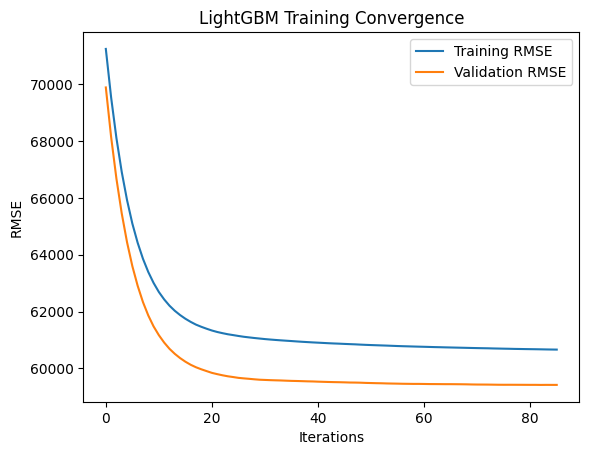

In [ ]:
from lightgbm import LGBMRegressor
from lightgbm import early_stopping

# יצירת מודל LGBMRegressor
LGBMRegressor_model = LGBMRegressor(
    objective='regression',
    metric='rmse',
    learning_rate=0.1,
    num_leaves=63,
    n_estimators=1000
)

# אימון המודל תוך מעקב אחרי סט אימות
LGBMRegressor_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_metric='rmse',
    callbacks=[early_stopping(stopping_rounds=3)],
)

# הצגת היסטוריית RMSE
plt.plot(LGBMRegressor_model.evals_result_['training']['rmse'], label='Training RMSE')
plt.plot(LGBMRegressor_model.evals_result_['valid_1']['rmse'], label='Validation RMSE')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('LightGBM Training Convergence')
plt.legend()
plt.show()


              Feature    Importance
2           job_title  3.269879e+14
0    experience_level  1.204860e+14
3  employee_residence  8.261739e+13
4        remote_ratio  1.244842e+13
5    company_location  1.062676e+13
6        company_size  3.145022e+12
1     employment_type  2.046168e+12


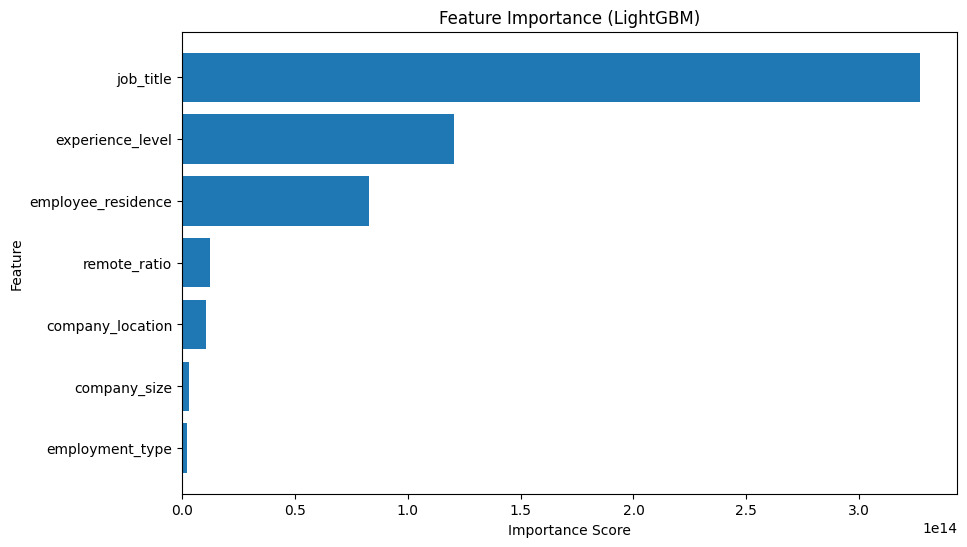

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# קבלת חשיבות הפיצ'רים (אפשר לבחור 'gain' או 'split')
importance = lgbm_model.feature_importance(importance_type='gain')
feature_names = X_train.columns

# יצירת טבלה עם תוצאות
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# הצגת 10 הפיצ'רים הכי חשובים
print(importance_df.head(10))

# ציור גרף החשיבות
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance (LightGBM)')
plt.gca().invert_yaxis()
plt.show()


              Feature  MI Score
2           job_title  0.447079
7        job_category  0.185401
0    experience_level  0.182259
3  employee_residence  0.158460
5    company_location  0.156215
4        remote_ratio  0.081996
6        company_size  0.066355
1     employment_type  0.008634


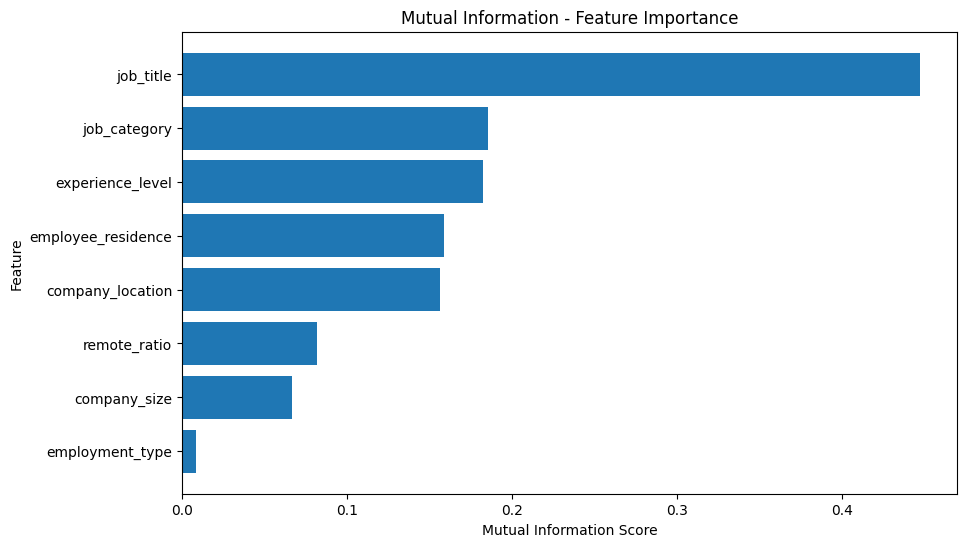

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import mutual_info_regression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# המרת משתנים קטגוריאליים למספרים
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)  # כעת קטגוריות חדשות יקבלו -1 ולא יקרסו

# חישוב Mutual Information
mi_scores = mutual_info_regression(X_train_encoded, y_train)

# יצירת DataFrame עם התוצאות
mi_df = pd.DataFrame({'Feature': X_train.columns, 'MI Score': mi_scores})
mi_df = mi_df.sort_values(by='MI Score', ascending=False)

# הדפסת 10 הפיצ'רים הכי חשובים
print(mi_df.head(10))

# הצגת גרף
plt.figure(figsize=(10, 6))
plt.barh(mi_df['Feature'], mi_df['MI Score'])
plt.xlabel('Mutual Information Score')
plt.ylabel('Feature')
plt.title('Mutual Information - Feature Importance')
plt.gca().invert_yaxis()
plt.show()


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[138]	training's rmse: 61100.3	valid_1's rmse: 59718.1


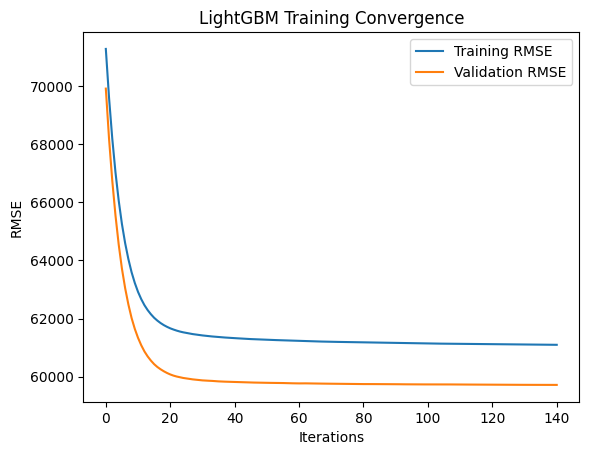

In [ ]:
# נשמור רק את הפיצ'רים שה-MI שלהם גדול מ-0.1
selected_features = mi_df[mi_df["MI Score"] > 0.1]["Feature"].tolist()

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# אימון המודל מחדש

LGBMRegressor_model.fit(
    X_train_selected, y_train,
    eval_set=[(X_train_selected, y_train), (X_test_selected, y_test)],
    eval_metric='rmse',
    callbacks=[early_stopping(stopping_rounds=3)],
)

# הצגת היסטוריית RMSE
plt.plot(LGBMRegressor_model.evals_result_['training']['rmse'], label='Training RMSE')
plt.plot(LGBMRegressor_model.evals_result_['valid_1']['rmse'], label='Validation RMSE')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('LightGBM Training Convergence')
plt.legend()
plt.show()



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# חישוב ממוצע, חציון וסטיית תקן של השכר לכל מקצוע
job_salary_stats = data.groupby("job_title")["salary_in_usd"].agg(["mean", "median", "std", "count"])

# עיגול כל הערכים ל-0 ספרות אחרי הנקודה
job_salary_stats = job_salary_stats.round(0)

# מיון לפי סטיית תקן בסדר יורד
job_salary_stats = job_salary_stats.sort_values(by="std", ascending=False)

# הצגת 10 המקצועות עם סטיית התקן הגבוהה ביותר
print(job_salary_stats.head(20))


                                           mean    median       std  count
job_title                                                                 
Finance Data Analyst                   141934.0   61896.0  157972.0      3
Technical Writer                       168049.0  102000.0  150576.0     19
AI Engineering Manager                 179930.0  179930.0  125610.0      2
ML Infrastructure Engineer             229300.0  216800.0  124251.0     18
Head of Machine Learning               288701.0  300000.0  123306.0      9
Cloud Developer                        211500.0  211500.0  118087.0      2
Machine Learning Performance Engineer  262500.0  262500.0  116673.0      2
Prompt Engineer                        190413.0  164492.0  113623.0     49
Enterprise Account Executive           257071.0  180000.0  113484.0     14
Machine Learning Tech Lead             183450.0  183450.0  107692.0      2
Deep Learning Engineer                 190808.0  150000.0  106790.0     12
Data Visualization Engine

<ipython-input-49-3fba189e4177>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  job_salary_stats = data.groupby("job_title")["salary_in_usd"].agg(["mean", "median", "std", "count"])


In [ ]:
import pandas as pd

# חישוב כמות הרשומות לכל תפקיד
job_counts = data["job_title"].value_counts()

# רשימת התפקידים שמופיעים לפחות 300 פעמים
jobs_to_keep = job_counts[job_counts >= 1000].index

# יצירת דאטה מסונן עם .copy() כדי למנוע SettingWithCopyWarning
filtered_df = data[data["job_title"].isin(jobs_to_keep)].copy()

# המרת משתנים קטגוריאליים לסוג category
categorical_features = ["job_title", "experience_level", "employment_type", "company_size", "company_location"]
for col in categorical_features:
    filtered_df[col] = filtered_df[col].astype("category")

# הצגת מספר הרשומות לאחר הסינון
print(f"מספר הרשומות אחרי סינון: {filtered_df.shape[0]}")

from sklearn.model_selection import train_test_split
# זיהוי עמודות טקסטואליות

# בחירת משתנים למודל
X = filtered_df.drop(columns=["salary_in_usd"])  # כל המשתנים חוץ מהשכר
y = filtered_df["salary_in_usd"]  # המשתנה המנובא (שכר)

# פיצול לסט אימון וסט בדיקה
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# הדפסת גודל הסטים
print(f"Train set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")


מספר הרשומות אחרי סינון: 63584
Train set size: 50867, Test set size: 12717


In [ ]:
# איתור כל העמודות מסוג object (קטגוריאליות)
categorical_features = filtered_df.select_dtypes(include=["object"]).columns.tolist()

# המרת כל העמודות הקטגוריאליות ל-type 'category'
for col in categorical_features:
    filtered_df[col] = filtered_df[col].astype("category")

# הצגת סוג הנתונים לאחר ההמרה
print(filtered_df.dtypes)


experience_level      category
employment_type       category
job_title             category
salary_in_usd            int64
employee_residence    category
remote_ratio          category
company_location      category
company_size          category
job_category          category
dtype: object


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[132]	training's rmse: 61218.7	valid_1's rmse: 62088.6


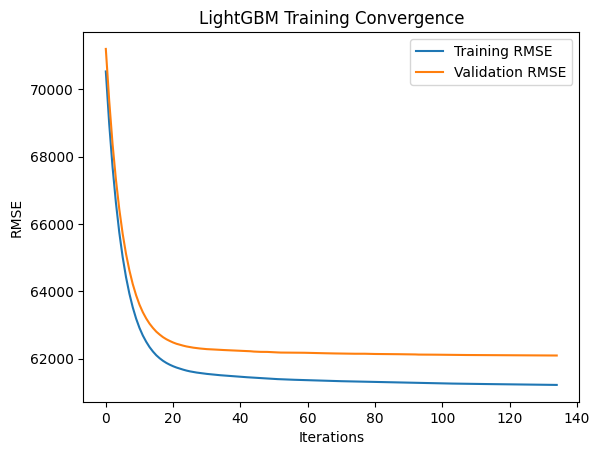

In [ ]:

X = filtered_df.drop(columns=["salary_in_usd"])
y = filtered_df["salary_in_usd"]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# יצירת מודל LGBMRegressor
LGBMRegressor_model_2 = LGBMRegressor(
    objective='regression',
    metric='rmse',
    learning_rate=0.1,
    num_leaves=63,
    n_estimators=1000
)

# אימון המודל תוך מעקב אחרי סט אימות
LGBMRegressor_model_2.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_metric='rmse',
    callbacks=[early_stopping(stopping_rounds=3)],
)

# הצגת היסטוריית RMSE
plt.plot(LGBMRegressor_model_2.evals_result_['training']['rmse'], label='Training RMSE')
plt.plot(LGBMRegressor_model_2.evals_result_['valid_1']['rmse'], label='Validation RMSE')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('LightGBM Training Convergence')
plt.legend()
plt.show()


Distribution of Job Titles:
job_title
Data Scientist               12201
Data Engineer                 9947
Software Engineer             8570
Data Analyst                  7774
Machine Learning Engineer     6103
                             ...  
Data Governance Engineer         0
Data Governance Architect        0
Data Governance Analyst          0
Data Governance                  0
Technology Integrator            0
Name: count, Length: 298, dtype: int64

Percentage of Job Titles:
job_title
Data Scientist               19.188790
Data Engineer                15.643873
Software Engineer            13.478234
Data Analyst                 12.226346
Machine Learning Engineer     9.598327
                               ...    
Data Governance Engineer      0.000000
Data Governance Architect     0.000000
Data Governance Analyst       0.000000
Data Governance               0.000000
Technology Integrator         0.000000
Name: count, Length: 298, dtype: float64


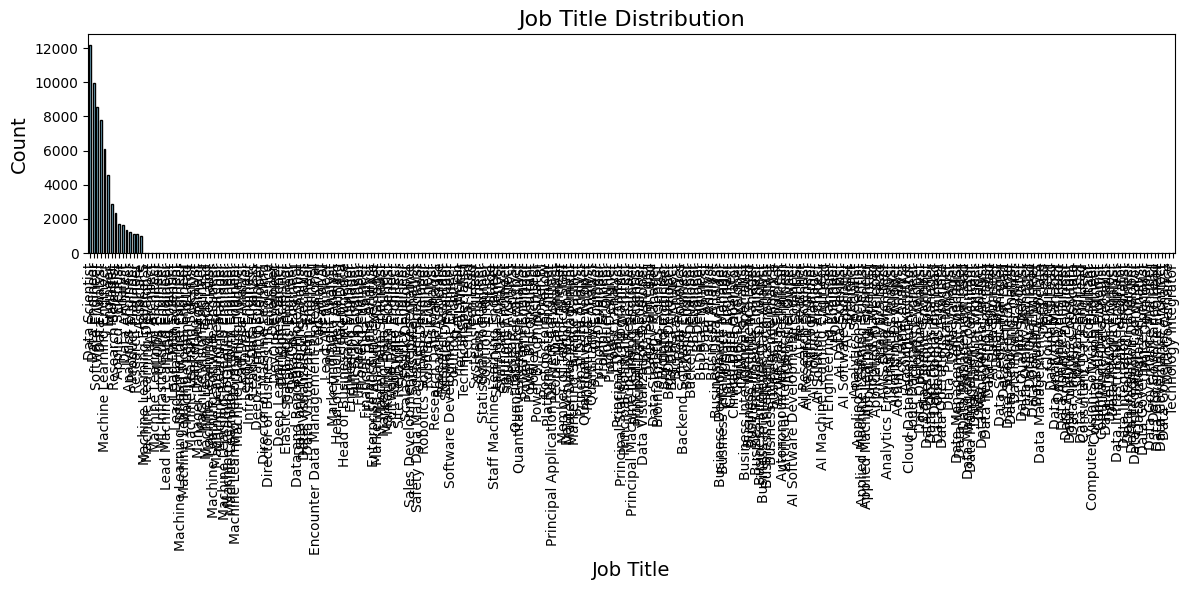

ZeroDivisionError: division by zero

In [ ]:
# Count the number of records for each job title
job_counts = filtered_df['job_title'].value_counts()

# Calculate the percentage of records for each job title
job_percentage = (job_counts / len(filtered_df)) * 100

# Display the distribution of job titles
print("Distribution of Job Titles:")
print(job_counts)

print("\nPercentage of Job Titles:")
print(job_percentage)

# Visualize the distribution
plt.figure(figsize=(12, 6))
job_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Job Title Distribution", fontsize=16)
plt.xlabel("Job Title", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Check for imbalance
imbalance_ratio = job_counts.max() / job_counts.min()
print(f"\nImbalance Ratio (Max/Min): {imbalance_ratio:.2f}")

if imbalance_ratio > 10:
    print("Warning: Significant imbalance detected!")
else:
    print("The data is relatively balanced.")


In [ ]:
import numpy as np

# יצירת עותק של הנתונים עם רעש אקראי
X_train_noisy = X_train + np.random.normal(0, X_train.std() * 0.1, X_train.shape)

# אימון מודל על הדאטה עם רעש
model_noisy = LGBMRegressor()
model_noisy.fit(X_train_noisy, y_train)
y_pred_noisy = model_noisy.predict(X_test)

# חישוב R^2 אחרי הוספת רעש
r2_noisy = r2_score(y_test, y_pred_noisy)
print(f"R^2 after adding noise: {r2_noisy:.4f}")


TypeError: 'Categorical' with dtype category does not support reduction 'std'

In [ ]:
model.save_model('lightgbm_model.txt')


In [ ]:
import pandas as pd
from tabulate import tabulate

# יצירת נתוני דוגמה
results = {
    "Model": ["Linear Regression", "Random Forest", "XGBoost", "LightGBM"],
    "MAE": [mae_lr, mae_rf, mae_xgb, mae_lgb],
    "RMSE": [rmse_lr, rmse_rf, rmse_xgb, rmse_lgb],
    "R²": [r2_lr, r2_rf, r2_xgb, r2_lgb],
    "Relative RMSE (%)": [relative_rmse_lr, relative_rmse_rf, relative_rmse_xgb, relative_rmse_lgb],
}

# יצירת DataFrame
results_df = pd.DataFrame(results)

# עיגול הנתונים ל-2 ספרות עשרוניות
df_rounded = results_df.copy()
df_rounded["MAE"] = df_rounded["MAE"].round(2)
df_rounded["RMSE"] = df_rounded["RMSE"].round(2)
df_rounded["R²"] = df_rounded["R²"].round(3)  # ערך קטן יותר, מדויק יותר
df_rounded["Relative RMSE (%)"] = df_rounded["Relative RMSE (%)"].round(2)

# הדפסת הטבלה המעוגלת
print(tabulate(df_rounded, headers="keys", tablefmt="pretty"))


+---+-------------------+----------+----------+-------+-------------------+
|   |       Model       |   MAE    |   RMSE   |  R²   | Relative RMSE (%) |
+---+-------------------+----------+----------+-------+-------------------+
| 0 | Linear Regression | 45789.69 | 61996.26 | 0.286 |       39.24       |
| 1 |   Random Forest   | 45000.94 | 61155.39 | 0.305 |       38.71       |
| 2 |      XGBoost      | 45008.57 | 61182.65 | 0.304 |       38.73       |
| 3 |     LightGBM      | 44907.41 | 61006.69 | 0.308 |       38.62       |
+---+-------------------+----------+----------+-------+-------------------+


In [ ]:
df_rounded.to_csv("model_comparison_results.csv", index=False)


In [ ]:
import matplotlib.pyplot as plt

models = df["Model"]
rmse = df["RMSE"]
mae = df["MAE"]

# גרף RMSE
plt.figure(figsize=(10, 6))
plt.bar(models, rmse, color="skyblue")
plt.title("RMSE Comparison Across Models")
plt.xlabel("Model")
plt.ylabel("RMSE")
plt.show()

# גרף MAE
plt.figure(figsize=(10, 6))
plt.bar(models, mae, color="orange")
plt.title("MAE Comparison Across Models")
plt.xlabel("Model")
plt.ylabel("MAE")
plt.show()


NameError: name 'df' is not defined

Similar results- now take only jobs with >= 50 entries

In [ ]:

# הפרדת משתנים תלויים ובלתי תלויים
X = filtered_data.drop(columns=['salary_in_usd'])  # הסרת עמודת המטרה
y = filtered_data['salary_in_usd']

# חלוקה לנתוני אימון ובדיקה
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# fot rf and xgboost
# One-Hot Encoding למשתנים קטגוריאליים
X_train_encoded = pd.get_dummies(X_train)
X_test_encoded = pd.get_dummies(X_test)


In [ ]:

# התאמת המודל
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_encoded, y_train)

# חיזוי
y_pred_rf = rf_model.predict(X_test_encoded)

# הערכת ביצועים
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print(f"Random Forest - MAE: {mae_rf:.2f}, RMSE: {rmse_rf:.2f}")
r2 = r2_score(y_test, y_pred_rf)
print(f"Explained Variance (R^2): {r2:.2f}")


Random Forest - MAE: 42060.22, RMSE: 55424.37
Explained Variance (R^2): 0.23


In [ ]:
# התאמת המודל
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train_encoded, y_train)

# חיזוי
y_pred_xgb = xgb_model.predict(X_test_encoded)

# הערכת ביצועים
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print(f"XGBoost - MAE: {mae_xgb:.2f}, RMSE: {rmse_xgb:.2f}")
r2 = r2_score(y_test, y_pred_xgb)


XGBoost - MAE: 41986.65, RMSE: 55327.50
Explained Variance (R^2): 0.24


In [ ]:
# הגדרת מודל XGBoost עם תמיכה בקטגוריות
xgb_model_categorized = xgb.XGBRegressor(random_state=42, enable_categorical=True)

# אימון המודל
xgb_model_categorized.fit(X_train, y_train)

# חיזוי על נתוני הבדיקה
y_pred_xgb = xgb_model_categorized.predict(X_test)

# הערכת ביצועים
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print(f"XGBoost - MAE: {mae_xgb:.2f}, RMSE: {rmse_xgb:.2f}")
r2 = r2_score(y_test, y_pred_xgb)
print(f"Explained Variance (R^2): {r2:.2f}")


XGBoost - MAE: 42332.03, RMSE: 56043.78
Explained Variance (R^2): 0.22


In [ ]:
# יצירת דאטה ל-LightGBM
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_columns)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data, categorical_feature=categorical_columns)

# פרמטרים למודל
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'verbose': -1
}

# אימון המודל
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=3),
        ]
)

# חיזוי
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# חישוב MSE
mse = mean_squared_error(y_test, y_pred)

# חישוב RMSE ידנית
rmse = np.sqrt(mse)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
r2 = r2_score(y_test, y_pred)
print(f"Explained Variance (R^2): {r2:.2f}")


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[142]	training's rmse: 54362	valid_1's rmse: 54834.2
Mean Squared Error: 3006787157.72
Root Mean Squared Error: 54834.18
Explained Variance (R^2): 0.25


Relative RMSE: 37.07%


In [ ]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# יצירת דאטה ל-LightGBM עם free_raw_data=False
train_data = lgb.Dataset(
    X_train,
    label=y_train,
    categorical_feature=categorical_columns,
    free_raw_data=False
)

test_data = lgb.Dataset(
    X_test,
    label=y_test,
    reference=train_data,
    categorical_feature=categorical_columns,
    free_raw_data=False
)

# פונקציה להרצת ניסויים
def run_lgb_experiment(params_list, train_data, test_data, X_test, y_test):
    results = []
    for params in params_list:
        # אימון המודל
        model = lgb.train(
            params,
            train_data,
            valid_sets=[train_data, test_data],
            num_boost_round=1000,
            callbacks=[lgb.early_stopping(stopping_rounds=10)]
        )

        # חיזוי
        y_pred = model.predict(X_test, num_iteration=model.best_iteration)

        # הערכת הביצועים
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        # שמירת התוצאה
        results.append({
            'params': params,
            'mse': mse,
            'rmse': rmse,
            'r2': r2
        })

    return results

# רשימת פרמטרים לניסוי
params_list = [
    {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'learning_rate': lr,
        'num_leaves': leaves,
        'min_data_in_leaf': min_data,
        'feature_fraction': feature_frac,
        'bagging_fraction': bagging_frac,
        'verbose': -1
    }
    for lr in [0.01, 0.05, 0.1]  # ניסוי עם Learning Rate משתנה
    for leaves in [15, 31, 63]  # מספר עלים
    for min_data in [20, 50, 100]  # מינימום דוגמאות בכל עלה
    for feature_frac in [0.6, 0.8, 1.0]  # אחוז פיצ'רים
    for bagging_frac in [0.6, 0.8, 1.0]  # אחוז דוגמאות
]

# הרצת הניסוי
results = run_lgb_experiment(params_list, train_data, test_data, X_test, y_test)

# הדפסת התוצאות הטובות ביותר
best_result = min(results, key=lambda x: x['rmse'])
print("Best Parameters:")
print(best_result['params'])
print(f"RMSE: {best_result['rmse']:.2f}, R^2: {best_result['r2']:.2f}")
